# Hidden Economic Champions: Discovering Underappreciated Global Powers

**Beyond the Headlines: Identifying Economic Excellence**: While global economic discourse typically focuses on the usual suspects—the United States, China, Germany, and other G7 nations—this analysis seeks to uncover the hidden champions: countries demonstrating exceptional economic performance across multiple dimensions but receiving limited international attention. These nations often represent the most compelling opportunities for trade partnerships, investment allocation, and economic diplomacy.

**Composite Performance Framework**: Using a sophisticated multi-dimensional scoring system that evaluates GDP growth, fiscal discipline (government debt), monetary stability (inflation control), and external balance strength (current account position), we can identify countries that excel not just in one area but maintain balanced, sustainable economic performance. This holistic approach reveals economies with genuine structural strength rather than temporary commodity booms or unsustainable growth spurts.

In [8]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load all 4 datasheets
account_balance = pd.read_csv('../data/current_account_balance_billionsUSD.csv')
gov_debt = pd.read_csv('../data/government_gross_debt.csv')
inflation = pd.read_csv('../data/inflation_rate.csv')
gdp_growth = pd.read_csv('../data/real_gdp_growth.csv')

# turn the whole process into a function for all datasets. 
def clean_account_data(df):
    # define regions to separate country and region dataset
    region_names = [
        "Africa (Region)", "Asia and Pacific", "Australia and New Zealand", "Caribbean",
        "Central America", "Central Asia and the Caucasus", "East Asia", "Eastern Europe",
        "Europe", "Middle East (Region)", "North Africa", "North America", "Pacific Islands",
        "South America", "South Asia", "Southeast Asia", "Sub-Saharan Africa (Region)",
        "Western Europe", "Western Hemisphere (Region)", "ASEAN-5", "Advanced economies",
        "Emerging and Developing Asia", "Emerging and Developing Europe",
        "Emerging market and developing economies", "Euro area", "European Union",
        "Latin America and the Caribbean", "Major advanced economies (G7)",
        "Middle East and Central Asia", "Other advanced economies", "Sub-Saharan Africa", "World"
    ]
    
    df = df.iloc[1:-2].copy()  # drop first row (extra header) and last two rows (footnotes)
    df.rename(columns={df.columns[0]: "country"}, inplace=True)
    df['country'] = df['country'].str.lower()
    df.replace('no data', np.nan, inplace=True)
    
    # ensure values are all numeric, orginally stored as an object. 
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # strip spaces
    df['country'] = df['country'].str.strip()

    # separate country and region dataset
    countries_df = df[~df['country'].isin([r.lower() for r in region_names])].copy()
    regions_df = df[df['country'].isin([r.lower() for r in region_names])].copy()
    
    return countries_df, regions_df

account_countries, account_regions = clean_account_data(account_balance)
debt_countries, debt_regions = clean_account_data(gov_debt)
inflation_countries, inflation_regions = clean_account_data(inflation)
gdp_countries, gdp_regions = clean_account_data(gdp_growth)


def reshape_df(df, value_name):
    df_long = df.melt(id_vars=['country'], var_name='year', value_name=value_name)
    df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
    return df_long

gdp_long = reshape_df(gdp_countries, 'gdp_growth')
debt_long = reshape_df(debt_countries, 'gov_debt')
infl_long = reshape_df(inflation_countries, 'inflation')
acct_long = reshape_df(account_countries, 'account_balance')


def reshape_region(df, value_name):
    df_long = df.melt(id_vars=['country'], var_name='year', value_name=value_name)
    df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
    return df_long

gdp_r_long   = reshape_region(gdp_regions, 'gdp_growth')
debt_r_long  = reshape_region(debt_regions, 'gov_debt')
infl_r_long  = reshape_region(inflation_regions, 'inflation')
acct_r_long  = reshape_region(account_regions, 'account_balance')

## Data Integration & Preprocessing: Building a Comprehensive Economic Dataset

**Multi-Source Data Harmonization**: Combining four critical macroeconomic datasets—GDP growth rates, government debt levels, inflation rates, and current account balances—requires careful preprocessing to ensure data quality and consistency. The cleaning function standardizes country naming conventions, handles missing data systematically, and separates country-level observations from regional aggregates, creating a robust foundation for cross-country comparative analysis.

**Temporal Reshaping & Quality Assurance**: Converting wide-format time series data into long-format structures enables sophisticated temporal analysis while maintaining data integrity. The preprocessing pipeline includes numeric conversion validation, whitespace normalization, and systematic handling of missing values to ensure that subsequent analytical steps operate on clean, reliable data. This methodological rigor is essential for generating trustworthy economic intelligence and avoiding spurious correlations or biased rankings.

                         country     score
71                        guyana  2.355676
101                    macao sar  1.239892
36   china, people's republic of  1.030334
167     taiwan province of china  0.693478
69                        guinea  0.623925
63                       georgia  0.525274
168                   tajikistan  0.512008
39       congo, dem. rep. of the  0.506251
47                      djibouti  0.477776
181         united arab emirates  0.476687


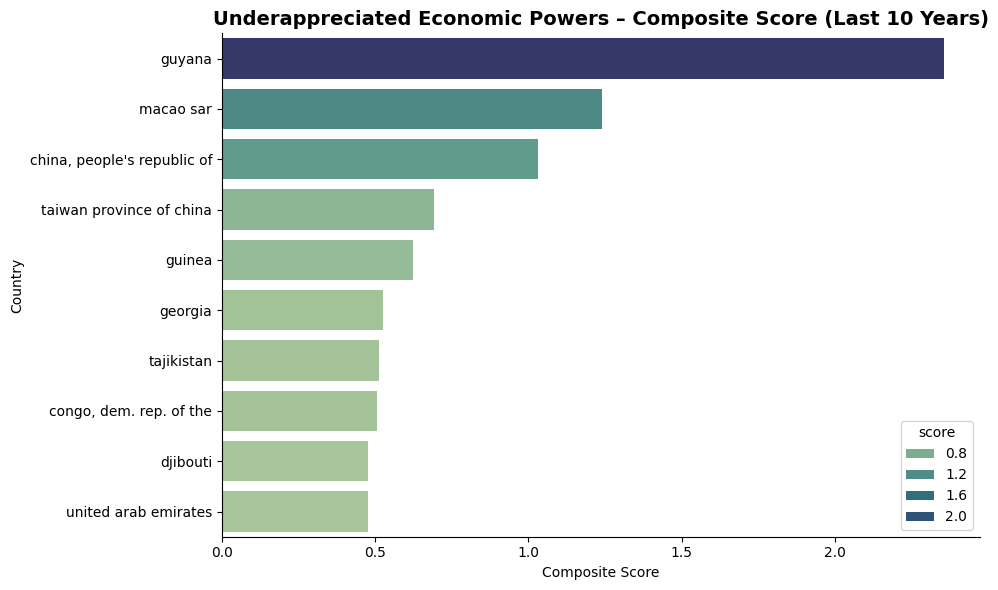

In [19]:
# Merge all country datasets into one
from functools import reduce

dfs_countries = [gdp_long, debt_long, infl_long, acct_long]
mega_countries = reduce(lambda left, right: pd.merge(left, right, on=['country', 'year'], how='inner'), dfs_countries)

# Keep only last 10 years
recent_data = mega_countries[mega_countries['year'] >= mega_countries['year'].max() - 9]

# Average each metric over last 10 years per country
country_avg = recent_data.groupby('country', as_index=False).agg({
    'gdp_growth': 'mean',
    'gov_debt': 'mean',
    'inflation': 'mean',
    'account_balance': 'mean'
})

# Standardise (z-scores)
for col in ['gdp_growth', 'gov_debt', 'inflation', 'account_balance']:
    if col in ['gov_debt', 'inflation']:  # lower is better, so reverse sign
        country_avg[col + '_z'] = -((country_avg[col] - country_avg[col].mean()) / country_avg[col].std())
    else:
        country_avg[col + '_z'] = (country_avg[col] - country_avg[col].mean()) / country_avg[col].std()

# Composite score
country_avg['score'] = country_avg[['gdp_growth_z', 'gov_debt_z', 'inflation_z', 'account_balance_z']].mean(axis=1)

# Remove obvious big economies
#exclude = ['united states', 'china', 'japan', 'germany', 'united kingdom', 'france', 'italy', 'canada']
hidden_gems = country_avg[~country_avg['country'].isin(exclude)].sort_values('score', ascending=False)

# Top 10 underappreciated economic powers
top_hidden_gems = hidden_gems.head(10)
print(top_hidden_gems[['country', 'score']])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_hidden_gems, x='score', y='country', palette='crest', hue='score')
plt.title("Underappreciated Economic Powers – Composite Score (Last 10 Years)", fontsize=14, weight='bold')
plt.xlabel("Composite Score")
plt.ylabel("Country")
sns.despine()
plt.tight_layout()
plt.show()


## Z-Score Normalization & Composite Scoring: Equalizing Economic Indicators

**Standardization Methodology**: Z-score normalization enables meaningful comparison across disparate economic indicators by converting each metric to a common scale centered on zero. This approach accounts for the natural variance in each indicator—GDP growth rates typically range 0-10%, while government debt can span 20-200% of GDP. The standardization process ensures that no single indicator dominates the composite score simply due to scale differences.

**Directional Scoring Logic**: Critical to the methodology is the proper orientation of indicators—higher GDP growth and current account surpluses represent positive performance, while lower government debt and inflation indicate superior fiscal and monetary discipline. The scoring system inverts debt and inflation z-scores to ensure all components contribute positively to overall economic performance assessment, creating an intuitive composite measure where higher scores consistently indicate better economic management across all dimensions.

                         country     score
36   china, people's republic of  2.249385
53             equatorial guinea  1.229058
101                    macao sar  1.104342
167     taiwan province of china  0.883101
30                      cambodia  0.736402
90            korea, republic of  0.731833
22        bosnia and herzegovina  0.657432
74                 hong kong sar  0.640737
71                        guyana  0.608440
188                      vietnam  0.598174


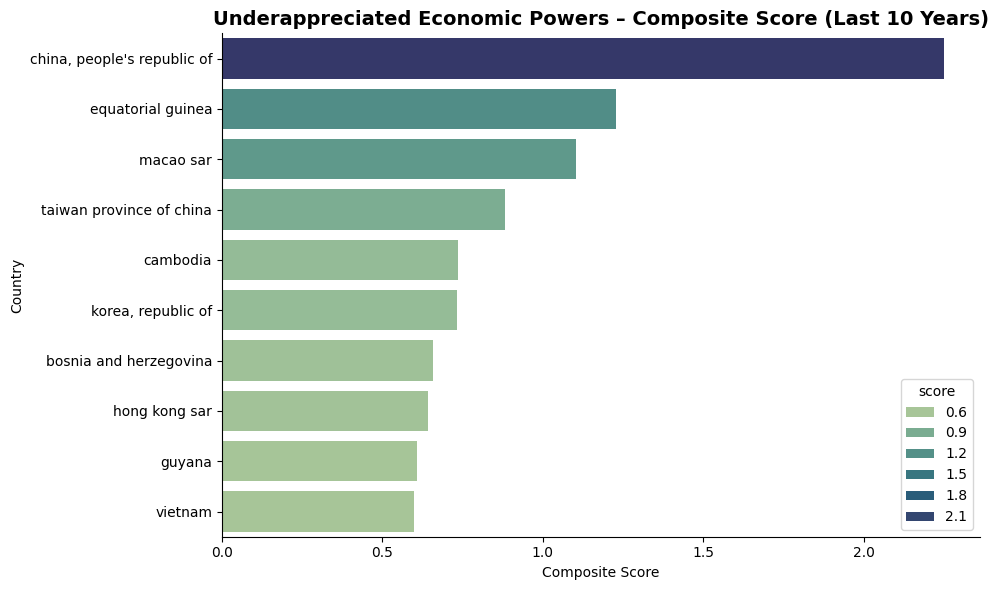

In [21]:
# Average each metric over last 10 years per country
country_avg = mega_countries.groupby('country', as_index=False).agg({
    'gdp_growth': 'mean',
    'gov_debt': 'mean',
    'inflation': 'mean',
    'account_balance': 'mean'
})

# Standardise (z-scores)
for col in ['gdp_growth', 'gov_debt', 'inflation', 'account_balance']:
    if col in ['gov_debt', 'inflation']:  # lower is better, so reverse sign
        country_avg[col + '_z'] = -((country_avg[col] - country_avg[col].mean()) / country_avg[col].std())
    else:
        country_avg[col + '_z'] = (country_avg[col] - country_avg[col].mean()) / country_avg[col].std()

# Composite score
country_avg['score'] = country_avg[['gdp_growth_z', 'gov_debt_z', 'inflation_z', 'account_balance_z']].mean(axis=1)

# Remove obvious big economies
#exclude = ['united states', 'china', 'japan', 'germany', 'united kingdom', 'france', 'italy', 'canada']
hidden_gems = country_avg[~country_avg['country'].isin(exclude)].sort_values('score', ascending=False)

# Top 10 underappreciated economic powers
top_hidden_gems = hidden_gems.head(10)
print(top_hidden_gems[['country', 'score']])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_hidden_gems, x='score', y='country', palette='crest', hue='score')
plt.title("Underappreciated Economic Powers – Composite Score (Last 10 Years)", fontsize=14, weight='bold')
plt.xlabel("Composite Score")
plt.ylabel("Country")
sns.despine()
plt.tight_layout()
plt.show()


## Strategic Filtering: Uncovering Hidden Economic Gems

**Beyond Major Economy Bias**: Mainstream economic analysis suffers from size bias, focusing disproportionately on large economies whose performance is already well-documented and analyzed. By systematically excluding the usual suspects—G7 nations plus major emerging markets like China and India—this analysis reveals mid-sized economies demonstrating exceptional performance that warrant increased attention from policymakers, investors, and trade strategists.

**Discovery of Underappreciated Excellence**: The filtering strategy uncovers countries achieving remarkable economic performance without the advantages of scale, natural resource endowments, or historical economic dominance. These hidden champions often represent the most dynamic and well-managed economies globally, offering insights into effective economic governance models and potentially superior risk-adjusted returns for strategic partnerships and investment allocation.

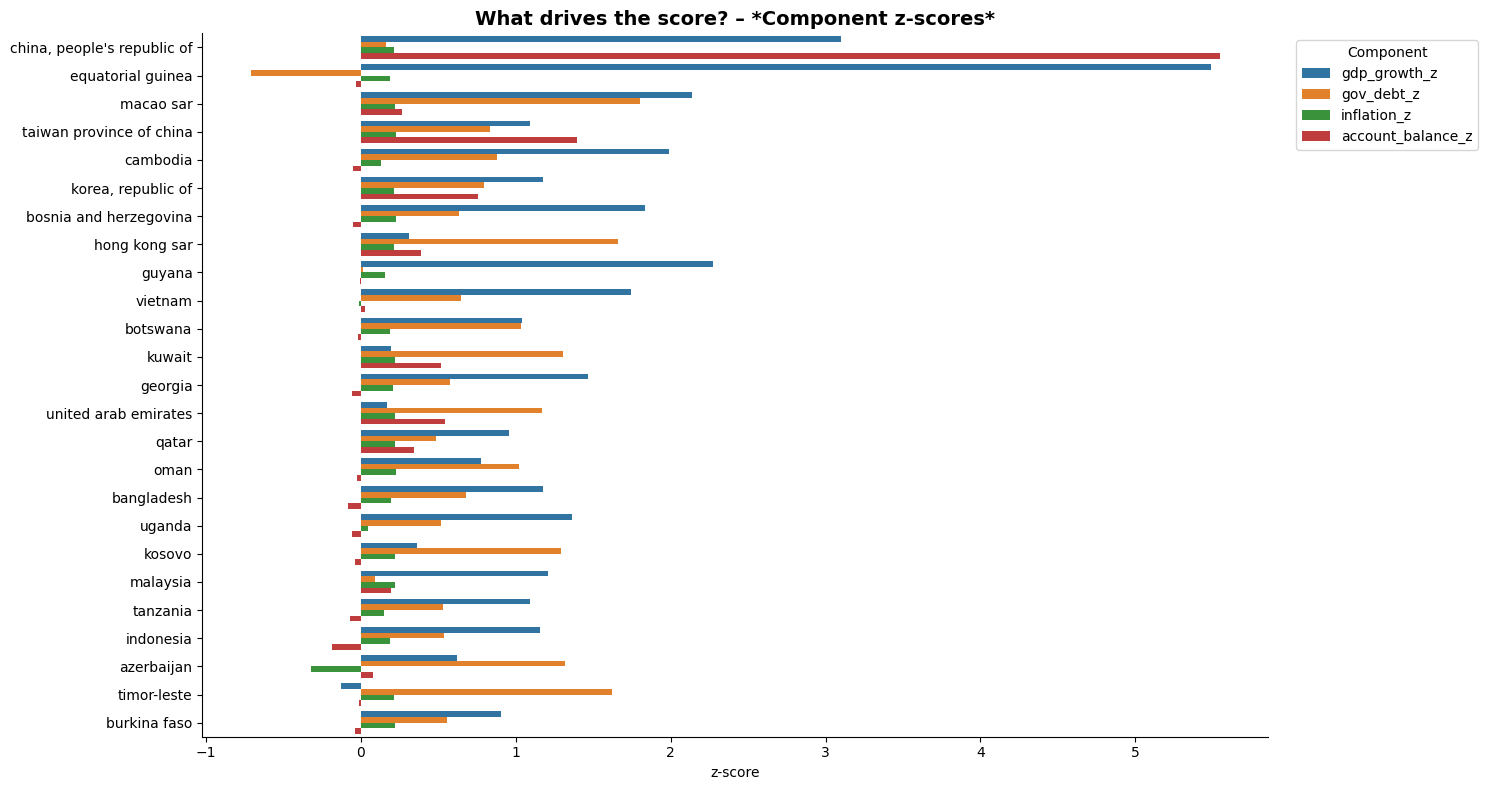

In [41]:
from functools import reduce
# Use your long country dfs already made: gdp_long, debt_long, infl_long, acct_long
dfs = [gdp_long, debt_long, infl_long, acct_long]
mega = reduce(lambda l, r: pd.merge(l, r, on=['country','year'], how='inner'), dfs)

recent = mega[mega['year'] >= mega['year'].max() - 100]
avg = recent.groupby('country', as_index=False).agg(
    gdp_growth=('gdp_growth','mean'),
    gov_debt=('gov_debt','mean'),
    inflation=('inflation','mean'),
    account_balance=('account_balance','mean')
)

# z-scores (higher = better): flip signs for debt & inflation
def z(x): return (x - x.mean())/x.std(ddof=0)
avg['gdp_growth_z']      =  z(avg['gdp_growth'])
avg['gov_debt_z']        = -z(avg['gov_debt'])
avg['inflation_z']       = -z(avg['inflation'])     # simple: lower inflation is better
avg['account_balance_z'] =  z(avg['account_balance'])
avg['score'] = avg[['gdp_growth_z','gov_debt_z','inflation_z','account_balance_z']].mean(axis=1)

# optional: de-headline
big = {'united states','china','japan','germany','united kingdom','france','italy','canada','india'}
avg_filtered = avg[~avg['country'].str.lower().isin(big)]

top = avg_filtered.sort_values('score', ascending=False).head(25)
parts = (top
         .melt(id_vars='country',
               value_vars=['gdp_growth_z','gov_debt_z','inflation_z','account_balance_z'],
               var_name='component', value_name='z'))
order = top['country'].tolist()
plt.figure(figsize=(15,8))
sns.barplot(data=parts, x='z', y='country', hue='component', order=order)
plt.title("What drives the score? – *Component z-scores*", fontsize=14, weight='bold')
plt.xlabel("z-score"); plt.ylabel(""); plt.legend(title="Component", bbox_to_anchor=(1.02,1), loc='upper left')
sns.despine(); plt.tight_layout(); plt.show()


## Component Analysis: Deconstructing Economic Success Drivers

**Performance Attribution Framework**: Understanding what drives top economic performance requires decomposing the composite scores into constituent elements. This component analysis reveals whether countries achieve high rankings through balanced excellence across all dimensions or domination in specific areas. Such granular insight is crucial for identifying best practices and understanding the sustainability of economic performance models.

**Strategic Intelligence for Policy Design**: The component breakdown provides actionable intelligence for economic policy formulation by revealing which combinations of fiscal discipline, growth promotion, monetary stability, and external balance management produce optimal results. Countries showing strength across multiple dimensions offer templates for comprehensive economic reform programs, while those excelling in specific areas provide specialized expertise for targeted policy interventions.

## Strategic Implications: Economic Intelligence for Global Positioning

**Investment & Partnership Intelligence**: This analysis identifies countries offering potentially superior risk-adjusted opportunities for trade expansion, foreign direct investment, and strategic economic partnerships. Hidden champions often provide access to growing markets with stable economic management, reduced competition from major powers, and governments motivated to attract international collaboration through favorable terms and supportive policies.

**Policy Learning & Best Practice Identification**: The top-performing economies revealed through this analysis represent natural laboratories for economic policy innovation and governance excellence. Understanding their success factors—whether through exceptional fiscal discipline, innovative growth strategies, effective inflation management, or sustainable external balance policies—provides valuable intelligence for economic reform programs and institutional development initiatives.

**Future-Oriented Economic Diplomacy**: As global economic power continues to distribute more evenly, early identification and engagement with emerging economic champions becomes crucial for maintaining strategic influence and accessing growth opportunities. This analytical framework provides a systematic approach to identifying the economic winners of tomorrow, enabling proactive rather than reactive international economic strategy.